# Pacotes

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
from collections import Counter
import numpy as np
from sklearn import feature_extraction, model_selection, naive_bayes, metrics
from imblearn.over_sampling import SMOTE
from sklearn.naive_bayes import MultinomialNB
import sklearn.metrics as sklm
import seaborn as sns
from sklearn.naive_bayes import ComplementNB
import numpy as np
from sklearn.metrics import confusion_matrix
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from imblearn.under_sampling import RandomUnderSampler

/usr/local/lib/python3.7/dist-packages/sklearn/externals/six.py:31: FutureWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:144: FutureWarning: The sklearn.neighbors.base module is  deprecated in version 0.22 and will be removed in version 0.24. The corresponding classes / functions should instead be imported from sklearn.neighbors. Anything that cannot be imported from sklearn.neighbors is now part of the private API.
  warnings.warn(message, FutureWarning)


[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.


# Conjunto de mensagens SMS a serem classificadas como spam ou mensagens legítimas:

In [12]:
sms = pd.read_csv('SMSSpamCollection', sep='\t', header=None)
sms.head()

,0,1
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


In [13]:
sms.columns = ['class', 'text']
sms.head()

,class,text
0,ham,"Go until jurong point, crazy.. Available only ..."
1,ham,Ok lar... Joking wif u oni...
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...
3,ham,U dun say so early hor... U c already then say...
4,ham,"Nah I don't think he goes to usf, he lives aro..."


# Análise exploratória do dataset

In [14]:
sms['class'].value_counts()/len(sms)

ham     0.865937
spam    0.134063
Name: class, dtype: float64

In [15]:
sms['class'].value_counts()

ham     4825
spam     747
Name: class, dtype: int64

Temos mais mensagens genuínas do que de spam no dataset, o que pode gerar problemas no momento de treinar o modelo.

In [16]:
Counter(' '.join(sms['text']).lower().split()).most_common(50)

[('to', 2237),
 ('i', 2217),
 ('you', 1921),
 ('a', 1433),
 ('the', 1329),
 ('u', 998),
 ('and', 968),
 ('is', 869),
 ('in', 859),
 ('my', 755),
 ('for', 704),
 ('your', 677),
 ('of', 614),
 ('me', 611),
 ('have', 571),
 ('call', 559),
 ('on', 521),
 ('are', 487),
 ('that', 470),
 ('it', 466),
 ('2', 457),
 ('so', 423),
 ('but', 422),
 ('or', 415),
 ('not', 411),
 ('at', 400),
 ('can', 386),
 ('ur', 385),
 ('if', 382),
 ('with', 379),
 ('will', 379),
 ("i'm", 377),
 ('be', 376),
 ('get', 375),
 ('just', 365),
 ('do', 364),
 ('we', 346),
 ('this', 312),
 ('when', 283),
 ('from', 277),
 ('&lt;#&gt;', 276),
 ('go', 265),
 ('up', 264),
 ('all', 261),
 ('no', 258),
 ('4', 255),
 ('how', 254),
 ('what', 252),
 ('now', 247),
 ('.', 241)]

É possível notar que as principais palavras são stopwords. Para uma melhor análise, precisamos retirá-las, pois elas não serão importantes na classificação.

In [18]:
feat_ext = feature_extraction.text.CountVectorizer(stop_words = 'english', encoding='ansi')
feat_ext.get_stop_words()
stop_words = feat_ext.get_stop_words()

In [19]:
sms_1 = ' '.join(sms['text']).lower().split()
sms_limpo = [word for word in sms_1 if word not in stop_words]

In [20]:
print(sms_limpo)

['jurong', 'point,', 'crazy..', 'available', 'bugis', 'n', 'great', 'world', 'la', 'e', 'buffet...', 'cine', 'got', 'amore', 'wat...', 'ok', 'lar...', 'joking', 'wif', 'u', 'oni...', 'free', 'entry', '2', 'wkly', 'comp', 'win', 'fa', 'cup', 'final', 'tkts', '21st', '2005.', 'text', 'fa', '87121', 'receive', 'entry', 'question(std', 'txt', "rate)t&c's", 'apply', "08452810075over18's", 'u', 'dun', 'say', 'early', 'hor...', 'u', 'c', 'say...', 'nah', "don't", 'think', 'goes', 'usf,', 'lives', 'freemsg', 'hey', 'darling', "it's", '3', "week's", 'word', 'back!', "i'd", 'like', 'fun', 'still?', 'tb', 'ok!', 'xxx', 'std', 'chgs', 'send,', '£1.50', 'rcv', 'brother', 'like', 'speak', 'me.', 'treat', 'like', 'aids', 'patent.', 'request', "'melle", 'melle', '(oru', 'minnaminunginte', 'nurungu', "vettam)'", 'set', 'callertune', 'callers.', 'press', '*9', 'copy', 'friends', 'callertune', 'winner!!', 'valued', 'network', 'customer', 'selected', 'receivea', '£900', 'prize', 'reward!', 'claim', '09061

In [21]:
Counter(sms_limpo).most_common(10)

[('u', 998),
 ('2', 457),
 ('ur', 385),
 ("i'm", 377),
 ('just', 365),
 ('&lt;#&gt;', 276),
 ('4', 255),
 ('.', 241),
 ('like', 236),
 ('got', 235)]

Temos como as palavras mais frequentes abreviações normalmente utilizadas em mensagens: u - you, 2 - to, ur - you are, 4 - for; Também temos I'm que deveria estar nas stopwords e pontuação. Algumas pontuações permanecem juntas das palavras, outro ponto a ser corrigido.


Dentre as mensagens de spam, também aparecem as abreviações comuns em sms, mas percebemos que uma palavra é muito frequente neste caso, e não tinha aparecido anteriormente, a palavra "free". Outras palavras como claim e replay, que eram esperadas, também surgem com frequência nas mensagens spam. 

Palavras que indiquem que a pessoa deva clicar em algo, que demonstre urgência em resposta ou algo muito fácil pode nos ajudar e indicar se é phishing. Já palavras imperativas, motivadoras que indiquem promoções, ou nome de empresas podem indicar spam.  


Também podemos pensar que as mensagens de spam indiquem algum link ou página, o que poderia ser mais facilmente identificado se separarmos as palavras também por pontos.

In [ ]:
# Carregando as Stopwords em uma lista
NLTK_stop_words_list=stopwords.words('english')
print(NLTK_stop_words_list)
print("Total numbers of stop words are ")
print(len(NLTK_stop_words_list))

['i', 'me', 'my', 'myself', 'we', 'our', 'ours', 'ourselves', 'you', "you're", "you've", "you'll", "you'd", 'your', 'yours', 'yourself', 'yourselves', 'he', 'him', 'his', 'himself', 'she', "she's", 'her', 'hers', 'herself', 'it', "it's", 'its', 'itself', 'they', 'them', 'their', 'theirs', 'themselves', 'what', 'which', 'who', 'whom', 'this', 'that', "that'll", 'these', 'those', 'am', 'is', 'are', 'was', 'were', 'be', 'been', 'being', 'have', 'has', 'had', 'having', 'do', 'does', 'did', 'doing', 'a', 'an', 'the', 'and', 'but', 'if', 'or', 'because', 'as', 'until', 'while', 'of', 'at', 'by', 'for', 'with', 'about', 'against', 'between', 'into', 'through', 'during', 'before', 'after', 'above', 'below', 'to', 'from', 'up', 'down', 'in', 'out', 'on', 'off', 'over', 'under', 'again', 'further', 'then', 'once', 'here', 'there', 'when', 'where', 'why', 'how', 'all', 'any', 'both', 'each', 'few', 'more', 'most', 'other', 'some', 'such', 'no', 'nor', 'not', 'only', 'own', 'same', 'so', 'than', '

In [ ]:
# Inserindo stopwords de um arquivo pessoal
custom_stop_word_list = ' '.join(pd.read_csv('StopWords.csv', sep=";")['SW']).lower().split()

final_stopword_list = custom_stop_word_list + NLTK_stop_words_list

Stopwords atualizadas.

In [ ]:
sms_1 = ' '.join(sms['text']).lower().replace('.', ' ').replace(',', ' ').replace('?', ' ? ').replace('!', ' ! ').replace('\\', ' \\ ').replace(':', ' : ').replace('-', ' - ').replace('_', ' _ ').replace('@', ' @ ').replace('$', ' $ ').split()
sms_limpo = [word for word in sms_1 if word not in final_stopword_list]
sms_limpo

['go',
 'jurong',
 'point',
 'crazy',
 'available',
 'bugis',
 'great',
 'world',
 'la',
 'buffet',
 'cine',
 'got',
 'amore',
 'wat',
 'ok',
 'lar',
 'joking',
 'wif',
 'oni',
 'free',
 'entry',
 'wkly',
 'comp',
 'win',
 'fa',
 'cup',
 'final',
 'tkts',
 '21st',
 'may',
 '2005',
 'text',
 'fa',
 '87121',
 'receive',
 'entry',
 'question(std',
 'txt',
 "rate)t&c's",
 'apply',
 "08452810075over18's",
 'dun',
 'say',
 'early',
 'hor',
 'already',
 'say',
 'nah',
 'think',
 'goes',
 'usf',
 'lives',
 'around',
 'though',
 'freemsg',
 'hey',
 'darling',
 '3',
 "week's",
 'word',
 'back',
 '!',
 "i'd",
 'like',
 'fun',
 'still',
 '?',
 'tb',
 'ok',
 '!',
 'xxx',
 'std',
 'chgs',
 'send',
 'å£1',
 '50',
 'rcv',
 'even',
 'brother',
 'like',
 'speak',
 'treat',
 'like',
 'aids',
 'patent',
 'per',
 'request',
 "'melle",
 'melle',
 '(oru',
 'minnaminunginte',
 'nurungu',
 "vettam)'",
 'set',
 'callertune',
 'callers',
 'press',
 '*9',
 'copy',
 'friends',
 'callertune',
 'winner',
 '!',
 '!',

In [ ]:
sms_ham = ' '.join(sms[sms['class'] == 'ham']['text']).lower().replace('.', ' ').replace(',', ' ').replace('?', ' ? ').replace('!', ' ! ').replace('\\', ' \\ ').replace(':', ' : ').replace(':', ' : ').replace('-', ' - ').replace('_', ' _ ').replace('@', ' @ ').replace('$', ' $ ').split()
sms_ham_limpo = [word for word in sms_ham if word not in final_stopword_list]

sms_spam = ' '.join(sms[sms['class'] == 'spam']['text']).lower().replace('.', ' ').replace(',', ' ').replace('?', ' ? ').replace('!', ' ! ').replace('\\', ' \\ ').replace(':', ' : ').replace(':', ' : ').replace('-', ' - ').replace('_', ' _ ').replace('@', ' @ ').replace('$', ' $ ').split()
sms_spam_limpo = [sla for sla in sms_spam if sla not in final_stopword_list]

In [ ]:
Counter(sms_spam_limpo).most_common(10)

[('!', 542),
 ('call', 355),
 ('-', 247),
 ('free', 219),
 (':', 179),
 ('?', 174),
 ('txt', 156),
 ('mobile', 127),
 ('text', 122),
 ('stop', 118)]

In [ ]:
Counter(sms_ham_limpo).most_common(10)

[('?', 1367),
 ('!', 839),
 (':', 561),
 ('-', 327),
 ('get', 304),
 ('\\', 292),
 ('ok', 282),
 ('&lt;#&gt;', 276),
 (')', 262),
 ('go', 249)]

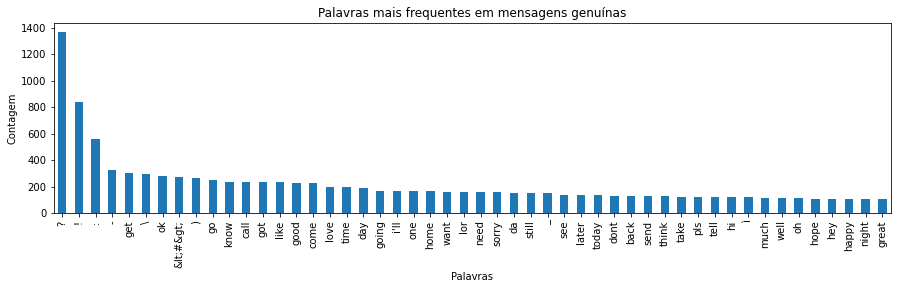

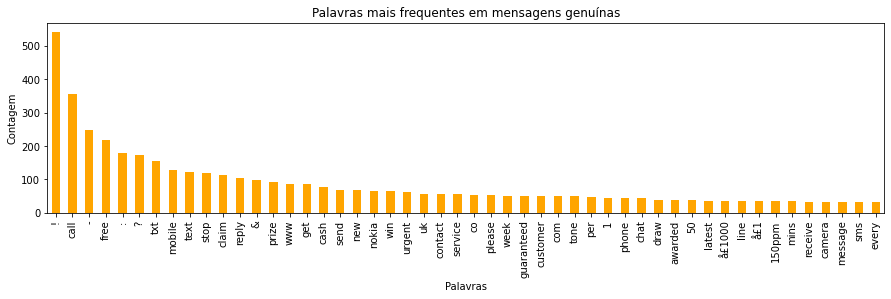

In [ ]:
count_ham = pd.DataFrame.from_dict(Counter(sms_ham_limpo).most_common(50))
count_ham.plot(kind = 'bar', legend = False, figsize = (15, 3.5))
plt.xticks(np.arange(50), count_ham[0])
plt.title('Palavras mais frequentes em mensagens genuínas')
plt.xlabel('Palavras')
plt.ylabel('Contagem')
plt.show()

count_spam = pd.DataFrame.from_dict(Counter(sms_spam_limpo).most_common(50))
count_spam.plot(kind = 'bar', legend = False, color = 'orange', figsize = (15, 3.5))
plt.xticks(np.arange(50), count_spam[0])
plt.title('Palavras mais frequentes em mensagens genuínas')
plt.xlabel('Palavras')
plt.ylabel('Contagem')
plt.show()


As pontuações que inicialmente pareciam diferenciar os grupos, agora aparecem em postos similares.

In [ ]:
sms_ham = ' '.join(sms[sms['class'] == 'ham']['text']).lower().replace('.', ' ').replace(',', ' ').replace('?', ' ').replace('!', ' ').replace('\\', ' \\ ').replace(':', ' ').replace('(', ' ').replace(')', ' ').replace('-', ' ').replace('_', ' ').replace('@', ' ').replace('$', ' ').replace('£', ' £ ').split()
sms_ham_limpo = [word for word in sms_ham if word not in final_stopword_list]

sms_spam = ' '.join(sms[sms['class'] == 'spam']['text']).lower().replace('.', ' ').replace(',', ' ').replace('?', ' ').replace('!', ' ').replace('\\', ' \\ ').replace(':', ' ').replace('(', ' ').replace(')', ' ').replace('-', ' ').replace('_', ' ').replace('@', ' ').replace('$', ' ').replace('£', ' £ ').split()
sms_spam_limpo = [sla for sla in sms_spam if sla not in final_stopword_list]

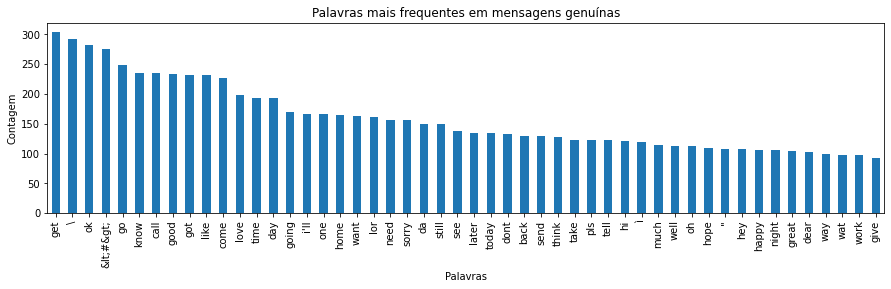

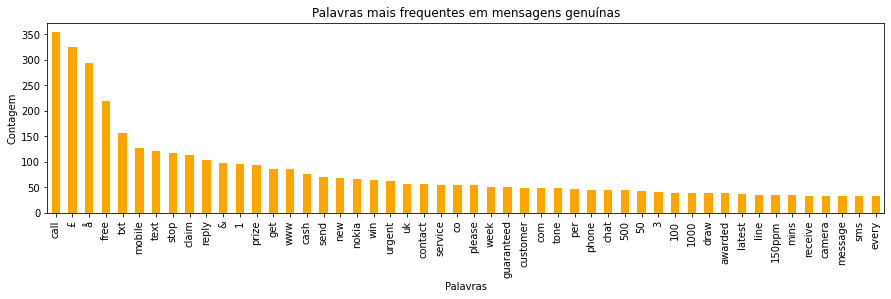

In [ ]:
count_ham = pd.DataFrame.from_dict(Counter(sms_ham_limpo).most_common(50))
count_ham.plot(kind = 'bar', legend = False, figsize = (15, 3.5))
plt.xticks(np.arange(50), count_ham[0])
plt.title('Palavras mais frequentes em mensagens genuínas')
plt.xlabel('Palavras')
plt.ylabel('Contagem')
plt.show()

count_spam = pd.DataFrame.from_dict(Counter(sms_spam_limpo).most_common(50))
count_spam.plot(kind = 'bar', legend = False, color = 'orange', figsize = (15, 3.5))
plt.xticks(np.arange(50), count_spam[0])
plt.title('Palavras mais frequentes em mensagens genuínas')
plt.xlabel('Palavras')
plt.ylabel('Contagem')
plt.show()

## Primeiro vamos aplicar a limpeza nos dados:

In [ ]:
def listToString(s): 
    str1 = " " 
    return (str1.join(s))

In [ ]:
sms['text_trat']=1

In [ ]:
for i in range(0,len(sms),1):
    a= sms['text'][i].lower().replace('.', ' ').replace(',', ' ').replace('?', ' ? ').replace('!', ' ').replace('\\', ' \\ ').replace(':', ' ').replace('(', ' ').replace(')', ' ').replace('-', ' ').replace('_', ' ').replace('@', ' ').replace('$', ' ').replace('£', ' £ ').split()
    sms['text_trat'][i] = listToString([sla for sla in a if sla not in final_stopword_list])

<ipython-input-103-1239fe5a5e0e>:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  sms['text_trat'][i] = listToString([sla for sla in a if sla not in final_stopword_list])
C:\Users\debor\anaconda3\lib\site-packages\pandas\core\indexing.py:670: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  iloc._setitem_with_indexer(indexer, value)


In [ ]:
sms

,class,text,text_trat
0,ham,"Go until jurong point, crazy.. Available only ...",go jurong point crazy available bugis great wo...
1,ham,Ok lar... Joking wif u oni...,ok lar joking wif oni
2,spam,Free entry in 2 a wkly comp to win FA Cup fina...,free entry wkly comp win fa cup final tkts 21s...
3,ham,U dun say so early hor... U c already then say...,dun say early hor already say
4,ham,"Nah I don't think he goes to usf, he lives aro...",nah think goes usf lives around though
...,...,...,...
5567,spam,This is the 2nd time we have tried 2 contact u...,2nd time tried contact å £ 750 pound prize cla...
5568,ham,Will Ì_ b going to esplanade fr home?,ì going esplanade fr home ?
5569,ham,"Pity, * was in mood for that. So...any other s...",pity * mood suggestions ?
5570,ham,The guy did some bitching but I acted like i'd...,guy bitching acted like i'd interested buying ...


In [ ]:
sms_trat= sms[['class','text_trat']]
sms_trat.columns = ['class', 'text']

Matriz esparsa para economizar memória!

Atributo  𝑗  (coluna) na linha  𝑖  é igual à quantidade de vezes que a palavra associada ao índice  𝑗  aparece na SMS de índice  𝑖 .

(Retirada do material de apoio)

In [ ]:
X = feat_ext.fit_transform(sms_trat['text'])
print(np.shape(X))
# Dicotomizar as classes
sms['class'] = sms['class'].map({'spam':1,'ham':0})

(5572, 8385)


Então temos nesta matriz 8385 palavras e 5572 SMSs

Separando os dados em treinamento e teste:


In [ ]:
X_train, X_test, y_train, y_test, idx_train, idx_test = model_selection.train_test_split(
    X, sms['class'], sms.index, test_size = 0.33,random_state= 200)

print([np.shape(X_train), np.shape(X_test)])

[(3733, 8385), (1839, 8385)]


Para balancear os dados de treinamento, utilizaremos a técnica SMOTE para o oversample, a fim de evitar a perda de informações das mensagens genuínas. 

Para o undersampling, foi adotada a porcentagem relativa, para que sejam descartados menos dados da classe majoritária.


In [ ]:
# sampling_strategy é o argumento que indica a porcentagem relativa da classe minoritária.

undersample = RandomUnderSampler(random_state=200, sampling_strategy=0.25)
X_train_US, y_train_US = undersample.fit_resample(X_train, y_train)
X_train_US.shape

(2495, 8385)

In [ ]:
oversample = SMOTE(random_state=200)
X_train_OS, y_train_OS = oversample.fit_resample(X_train, y_train.ravel())
X_train_OS.shape

(6468, 8385)

In [ ]:
X_train.shape

(3733, 8385)

In [ ]:
y_train.shape

(3733,)

# Modelagem Multinomial Naive Bayes

https://towardsdatascience.com/text-classification-using-naive-bayes-theory-a-working-example-2ef4b7eb7d5a
https://scikit-learn.org/stable/modules/naive_bayes.html

 * Consideramos a independência condicional entre os atributos, isto é a ocorrência das palavras não se influenciam.
 
 * Multinomial Naïve Bayes considera um vetor de característica onde um determinado termo representa o número de vezes que aparece, isto é, a frequência.

## Primeiro usamos o Oversampling para trinamento do modelo

In [ ]:
Classificador_OS = MultinomialNB().fit(X_train_OS,y_train_OS)

Probabilidade de 0.4 foi a que obteve melhor retorno na tabela de confusão. Então adotaremos este corte na probabilidade ao invés do default 0.5.

In [ ]:
aux=(Classificador_OS.predict_proba(X_train_OS)[:,1]>0.4).astype(int)
tabela=confusion_matrix(y_train_OS,aux)
tabela

array([[3158,   76],
       [  36, 3198]], dtype=int64)

<AxesSubplot:>

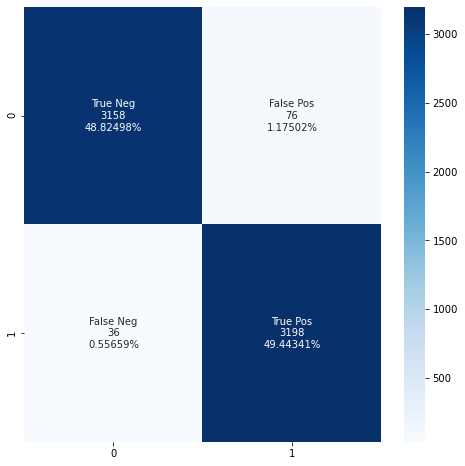

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                tabela.flatten()]
group_percentages = ["{0:.5%}".format(value) for value in
                     tabela.flatten()/np.sum(tabela)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

sns.heatmap(tabela, annot=labels, fmt="", cmap='Blues')

# Verificar teste

In [ ]:
aux=(Classificador_OS.predict_proba(X_test)[:,1]>0.4).astype(int)
tabela=confusion_matrix(y_test,aux)
tabela

array([[1506,   85],
       [  14,  234]], dtype=int64)

<AxesSubplot:>

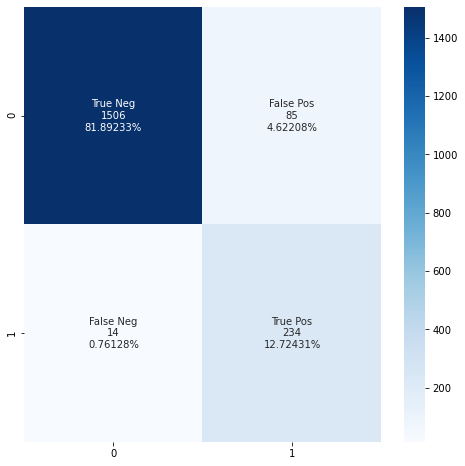

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                tabela.flatten()]
group_percentages = ["{0:.5%}".format(value) for value in
                     tabela.flatten()/np.sum(tabela)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

sns.heatmap(tabela, annot=labels, fmt="", cmap='Blues')

In [ ]:
Pop = y_test.shape[0]
N = sum((aux==0)*1)
P = sum((aux==1)*1)

VN = tabela[0, 0]
FP = tabela[0, 1]
FN = tabela[1, 0]
VP = tabela[1, 1]

Prev = P/Pop
Acc = (VN + VP)/Pop

FPR = FP/N
TNR = VN/N
TPR = VP/P
FNR = FN/P

FOR = FN/(VN + FN)
PPV = VP/(FP + VP)
NPV = VN/(VN + FN)
FDR = FP/(FP + VP)

F1 = 2/(1/PPV + 1/TPR)

print('Prevalência:', Prev)
print('Acurácia:', Acc)
print('Taxa de falsos positivos:', FPR)
print('Taxa de verdadeiros negativos (Especificidade):', TNR)
print('Taxa de verdadeiros positivos (Recall):', TPR)
print('Taxa de falsos negativos:', FNR)
print('False omission rate:', FOR)
print('Valor preditivo positivo (Precisão):', PPV)
print('Valor preditivo negativo:', NPV)
print('False discovery rate:', FDR)
print('F1 Score:', F1)

Prevalência: 0.17346383904295812
Acurácia: 0.9461663947797716
Taxa de falsos positivos: 0.05592105263157895
Taxa de verdadeiros negativos (Especificidade): 0.9907894736842106
Taxa de verdadeiros positivos (Recall): 0.7335423197492164
Taxa de falsos negativos: 0.0438871473354232
False omission rate: 0.009210526315789473
Valor preditivo positivo (Precisão): 0.7335423197492164
Valor preditivo negativo: 0.9907894736842106
False discovery rate: 0.2664576802507837
F1 Score: 0.7335423197492164


A proporção de SPAM nos dados é de aproximadamente 13%, a prevalência é de 17%, podemos dizer que é algo próximo do esperado.
Acurácia de 0.95, e F1 Score de 0.73 é um bom resultado para o modelo.
Especificidade de 0.99 indica que muito dificilmente mensagens genuínas serão classificadas erroneamente como spam.
Mas uma taxa de verdadeiros positivos de 0.73, indica que pelo modelo, está passando mais spams como genuínas do que o desejável.


## Agora o Undersampling para trinamento do modelo

In [ ]:
Classificador_US = MultinomialNB().fit(X_train_US,y_train_US)

aux=(Classificador_US.predict_proba(X_train_US)[:,1]>0.5).astype(int)
tabela=confusion_matrix(y_train_US,aux)
tabela


array([[1988,    8],
       [  10,  489]], dtype=int64)

O corte em 0.5 aqui realmente parece o que melhor equilibra os erros

<AxesSubplot:>

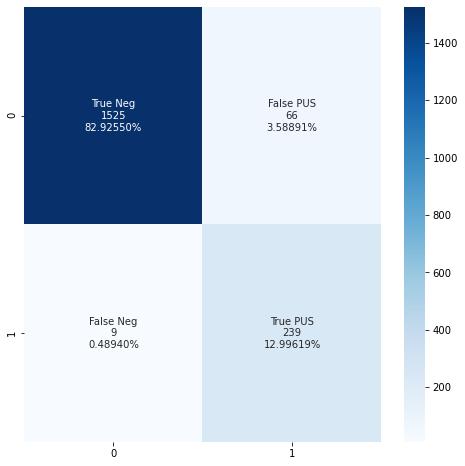

In [ ]:

group_names = ["True Neg","False PUS","False Neg","True PUS"]
group_counts = ["{0:0.0f}".format(value) for value in
                tabela.flatten()]
group_percentages = ["{0:.5%}".format(value) for value in
                     tabela.flatten()/np.sum(tabela)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

sns.heatmap(tabela, annot=labels, fmt="", cmap='Blues')


## Verificar teste

In [ ]:
aux=(Classificador_US.predict_proba(X_test)[:,1]>0.5).astype(int)
tabela=confusion_matrix(y_test,aux)
tabela


array([[1556,   35],
       [  14,  234]], dtype=int64)

<AxesSubplot:>

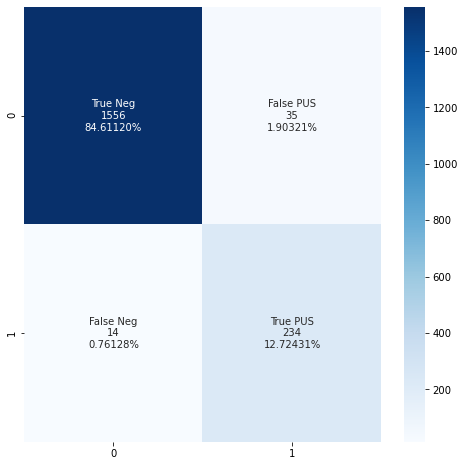

In [ ]:
group_names = ["True Neg","False PUS","False Neg","True PUS"]
group_counts = ["{0:0.0f}".format(value) for value in
                tabela.flatten()]
group_percentages = ["{0:.5%}".format(value) for value in
                     tabela.flatten()/np.sum(tabela)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

sns.heatmap(tabela, annot=labels, fmt="", cmap='Blues')


In [ ]:

Pop = y_test.shape[0]
N = sum((aux==0)*1)
P = sum((aux==1)*1)

VN = tabela[0, 0]
FP = tabela[0, 1]
FN = tabela[1, 0]
VP = tabela[1, 1]

Prev = P/Pop
Acc = (VN + VP)/Pop

FPR = FP/N
TNR = VN/N
TPR = VP/P
FNR = FN/P

FOR = FN/(VN + FN)
PPV = VP/(FP + VP)
NPV = VN/(VN + FN)
FDR = FP/(FP + VP)

F1 = 2/(1/PPV + 1/TPR)

print('Prevalência:', Prev)
print('Acurácia:', Acc)
print('Taxa de falsos positivos:', FPR)
print('Taxa de verdadeiros negativos (Especificidade):', TNR)
print('Taxa de verdadeiros positivos (Recall):', TPR)
print('Taxa de falsos negativos:', FNR)
print('False omission rate:', FOR)
print('Valor preditivo positivo (Precisão):', PPV)
print('Valor preditivo negativo:', NPV)
print('False discovery rate:', FDR)
print('F1 Score:', F1)

Prevalência: 0.14627514953779228
Acurácia: 0.9733550842849374
Taxa de falsos positivos: 0.022292993630573247
Taxa de verdadeiros negativos (Especificidade): 0.9910828025477707
Taxa de verdadeiros positivos (Recall): 0.8698884758364313
Taxa de falsos negativos: 0.05204460966542751
False omission rate: 0.008917197452229299
Valor preditivo positivo (Precisão): 0.8698884758364313
Valor preditivo negativo: 0.9910828025477707
False discovery rate: 0.13011152416356878
F1 Score: 0.8698884758364313


A proporção de SPAM nos dados é de aproximadamente 13%, a prevalência é de 15%, está próximo do esperado do que no modelo anterior.
Acurácia de 0.97, e F1 Score de 0.87 é um bom resultado para o modelo.
Especificidade de 0.99 indica que muito dificilmente mensagens genuínas serão classificadas erroneamente como spam.
Mas uma taxa de verdadeiros positivos de 0.86, indica que pelo modelo ainda está passando uma quantidade maior do que o desejável de spams como genuínas.


# Modelagem Complement Naive Bayes

 * Consideramos a independência condicional entre os atributos, isto é a ocorrência das palavras não se influenciam.
 
 * CNB é uma adaptação do Multinomial Naive Bayes, sendo que é particularmente adequado para conjuntos de dados desbalanceados.

In [ ]:
Classificador2 = ComplementNB().fit(X_train,y_train)

In [ ]:
aux=(Classificador2.predict_proba(X_train)[:,1]>0.7).astype(int)
tabela=confusion_matrix(y_train,aux)
tabela

array([[3205,   29],
       [   9,  490]], dtype=int64)

Então adotaremos o corte de 0.7 na probabilidade ao invés do default 0.5.

<AxesSubplot:>

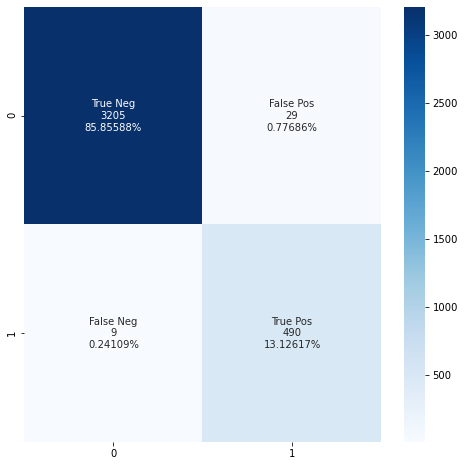

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                tabela.flatten()]
group_percentages = ["{0:.5%}".format(value) for value in
                     tabela.flatten()/np.sum(tabela)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

sns.heatmap(tabela, annot=labels, fmt="", cmap='Blues')

## Verificar teste

In [ ]:
aux=(Classificador2.predict_proba(X_test)[:,1]>0.7).astype(int)
tabela=confusion_matrix(y_test,aux)
tabela

array([[1525,   66],
       [   9,  239]], dtype=int64)

<AxesSubplot:>

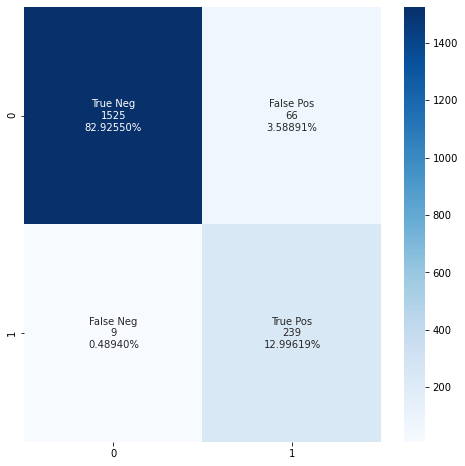

In [ ]:
group_names = ["True Neg","False Pos","False Neg","True Pos"]
group_counts = ["{0:0.0f}".format(value) for value in
                tabela.flatten()]
group_percentages = ["{0:.5%}".format(value) for value in
                     tabela.flatten()/np.sum(tabela)]
labels = [f"{v1}\n{v2}\n{v3}" for v1, v2, v3 in
          zip(group_names,group_counts,group_percentages)]
labels = np.asarray(labels).reshape(2,2)
f = plt.figure()
f.set_figwidth(8)
f.set_figheight(8)

sns.heatmap(tabela, annot=labels, fmt="", cmap='Blues')

In [ ]:
Pop = y_test.shape[0]
N = sum((aux==0)*1)
P = sum((aux==1)*1)

VN = tabela[0, 0]
FP = tabela[0, 1]
FN = tabela[1, 0]
VP = tabela[1, 1]

Prev = P/Pop
Acc = (VN + VP)/Pop

FPR = FP/N
TNR = VN/N
TPR = VP/P
FNR = FN/P

FOR = FN/(VN + FN)
PPV = VP/(FP + VP)
NPV = VN/(VN + FN)
FDR = FP/(FP + VP)

F1 = 2/(1/PPV + 1/TPR)

print('Prevalência:', Prev)
print('Acurácia:', Acc)
print('Taxa de falsos positivos:', FPR)
print('Taxa de verdadeiros negativos (Especificidade):', TNR)
print('Taxa de verdadeiros positivos (Recall):', TPR)
print('Taxa de falsos negativos:', FNR)
print('False omission rate:', FOR)
print('Valor preditivo positivo (Precisão):', PPV)
print('Valor preditivo negativo:', NPV)
print('False discovery rate:', FDR)
print('F1 Score:', F1)

Prevalência: 0.1658510059815117
Acurácia: 0.9592169657422512
Taxa de falsos positivos: 0.04302477183833116
Taxa de verdadeiros negativos (Especificidade): 0.9941329856584094
Taxa de verdadeiros positivos (Recall): 0.7836065573770492
Taxa de falsos negativos: 0.029508196721311476
False omission rate: 0.005867014341590613
Valor preditivo positivo (Precisão): 0.7836065573770492
Valor preditivo negativo: 0.9941329856584094
False discovery rate: 0.21639344262295082
F1 Score: 0.7836065573770492


A proporção de SPAM nos dados é de aproximadamente 13%, a prevalência é de 17%, assim como anteriormente, podemos dizer que é algo próximo do esperado. Acurácia de 0.96, e F1 Score de 0.78 é um bom resultado para o modelo, mas não melhor do que o modelo testado anteriormente. Especificidade de 0.99 indica que muito dificilmente mensagens genuínas serão classificadas erroneamente como spam. Mas uma taxa de verdadeiros positivos de 0.78, ainda não é o desejável, ainda pode gerar incômodo ao usuário.